In [1]:
import time
import random
import pandas as pd
import numpy as np
import gc
import re
import torch
from torchtext import data
import spacy
from tqdm import tqdm_notebook, tnrange
from tqdm.auto import tqdm
import string
import math
import operator
import pkg_resources
from pyphen import Pyphen

tqdm.pandas(desc='Progress')
from collections import Counter
from textblob import TextBlob
from nltk import word_tokenize

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.autograd import Variable
from torchtext.data import Example
import torchtext
import os

from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, CuDNNLSTM, Embedding, Dropout, Activation, CuDNNGRU, Conv1D
from keras.layers import Bidirectional, GlobalMaxPool1D, Flatten, GlobalAveragePooling1D
from keras.optimizers import Adam
from keras.models import Model
from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints, optimizers, layers

# cross validation and metrics
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import f1_score, accuracy_score, recall_score, mean_squared_error
from torch.optim.optimizer import Optimizer
from unidecode import unidecode

Using TensorFlow backend.


In [2]:
# first try? the word2vec model

# Initial Parameters

In [3]:
embed_size = 300 # how big is each word vector
max_features = 120000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 70 # max number of words in a question to use
batch_size = 512 # how many samples to process at once
n_epochs = 40 # how many times to iterate over all samples
n_splits = 5 # Number of K-fold Splits
SEED = 2024

# Preprocessing the data

In [4]:
import psutil
from multiprocessing import Pool
num_partitions = 8 # number of partitions to split dataframe
num_cores = psutil.cpu_count() # number of cores on your machine
print('number of cores: ', num_cores)

number of cores:  2


In [5]:
# function to run parallelly
def df_parallelize_run(df, func):
    df_split = np.array_split(df, num_partitions)
    pool = Pool(num_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

In [6]:
def seed_everything(seed = 1029):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()

In [7]:
def build_vocab(texts):
    sentences = texts.apply(lambda x: x.split()).values
    vocab = {}
    for sentence in sentences:
        for word in sentence:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab

def known_contractions(embed):
    known = []
    for contract in contraction_mapping:
        if contract in embed:
            known.append(contract)
    return known

def clean_contractions(text, mapping):
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        if s in text:
            text = text.replace(s, "'")
    text = ' '.join([mapping[t] if t in mapping else t for t in text.split(" ")])
    return text

def correct_spelling(x, dic):
    for word in dic.keys():
        if word in text:
            x = x.replace(word, dic[word])
    return x

def unknown_punct(embed, punct):
    unknown = ''
    for p in punct:
        if p not in embed:
            unknown += p
            unknown += ' '
    return unknown

def clean_numbers(x):
    x = re.sub('[0-9]{5,}', '#####', x)
    x = re.sub('[0-9]{4}', '####', x)
    x = re.sub('[0-9]{3}', '###', x)
    x = re.sub('[0-9]{2}', '##', x)
    return x

def clean_special_chars(text, punct, mapping):
    for p in mapping:
        if p in text:
            text = text.replace(p, mapping[p])
    
    for p in punct:
        if p in text:
            text = text.replace(p, ' ' + str(p) + ' ')
    
    specials = {'\u200b': ' ', '…': ' ... ', '\ufeff': '', 'करना': '', 'है': ''}  # Other special characters that I have to deal with in last
    for s in specials:
        if s in text:
            text = text.replace(s, specials[s])
    
    return text

def add_lower(embedding, vocab):
    count = 0
    for word in vocab:
        if word in embedding and word.lower() not in embedding:  
            embedding[word.lower()] = embedding[word]
            count += 1
    print("Added " + str(count) + " words to embedding")   
    
puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£', 
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', 
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', 
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', 
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]

def clean_text(x):
    x = str(x)
    for punct in puncts:
        if punct in x:
            x = x.replace(punct, ' ' + str(punct) + ' ')
    return x

mispell_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have", 'colour': 'color', 'centre': 'center', 'favourite': 'favorite', 'travelling': 'traveling', 'counselling': 'counseling', 'theatre': 'theater', 'cancelled': 'canceled', 'labour': 'labor', 'organisation': 'organization', 'wwii': 'world war 2', 'citicise': 'criticize', 'youtu ': 'youtube ', 'Qoura': 'Quora', 'sallary': 'salary', 'Whta': 'What', 'narcisist': 'narcissist', 'howdo': 'how do', 'whatare': 'what are', 'howcan': 'how can', 'howmuch': 'how much', 'howmany': 'how many', 'whydo': 'why do', 'doI': 'do I', 'theBest': 'the best', 'howdoes': 'how does', 'mastrubation': 'masturbation', 'mastrubate': 'masturbate', "mastrubating": 'masturbating', 'pennis': 'penis', 'Etherium': 'Ethereum', 'narcissit': 'narcissist', 'bigdata': 'big data', '2k17': '2017', '2k18': '2018', 'qouta': 'quota', 'exboyfriend': 'ex boyfriend', 'airhostess': 'air hostess', "whst": 'what', 'watsapp': 'whatsapp', 'demonitisation': 'demonetization', 'demonitization': 'demonetization', 'demonetisation': 'demonetization'}

def _get_mispell(mispell_dict):
    mispell_re = re.compile('(%s)' % '|'.join(mispell_dict.keys()))
    return mispell_dict, mispell_re

mispellings, mispellings_re = _get_mispell(mispell_dict)
def replace_typical_misspell(text):
    def replace(match):
        return mispellings[match.group(0)]
    return mispellings_re.sub(replace, text)

#############################################
# add features in the datasets
#############################################
def add_features(df):
    df.loc[:, 'app_desc'] = df.loc[:,'app_desc'].progress_apply(lambda x:str(x))
    df.loc[:,'total_length'] = df.loc[:,'app_desc'].progress_apply(len)
    df.loc[:,'capitals'] = df.loc[:,'app_desc'].progress_apply(lambda comment: sum(1 for c in comment if c.isupper()))
    df.loc[:,'caps_vs_length'] = df.progress_apply(lambda row: float(row['capitals'])/float(row['total_length']),
                                axis=1)
    df.loc[:,'num_words'] = df.app_desc.str.count('\S+')
    df.loc[:,'num_unique_words'] = df.loc[:,'app_desc'].progress_apply(lambda comment: len(set(w for w in comment.split())))
    df.loc[:,'words_vs_unique'] = df.loc[:,'num_unique_words'] / df['num_words']  
    df.loc[:,'size_bytes_in_MB'] = df.loc[:,'size_bytes'] / (1024 * 1024.0)
    df.loc[:,'isNotFree'] = df.loc[:,'price'].apply(lambda x: 1 if x > 0 else 0)
    df.loc[:,'isNotGame'] = df.loc[:,'prime_genre'].apply(lambda x : 1 if x == 'Games' else 0)
    feature_list = ['total_length', 'num_words', 'num_unique_words', 'caps_vs_length', 'size_bytes_in_MB', 'isNotGame', 'isNotFree']
    return df, feature_list

In [8]:
print(os.listdir('../input'))

['quora-insincere-questions-classification', 'app-store-apple-data-set-10k-apps']


# Load the Dataset

In [9]:
#############################################
# load and preprocess the datasets
#############################################
target = 'user_rating_ver'
def load_and_prec():
    
    DATA_PATH = "../input"

    ## Data Read and Join
    data = pd.read_csv(os.path.join(DATA_PATH,"app-store-apple-data-set-10k-apps/AppleStore.csv"))
    description_data = pd.read_csv(os.path.join(DATA_PATH,"app-store-apple-data-set-10k-apps/appleStore_description.csv"))
    # Join the Data
    data = data.set_index("id")
    description_data = description_data.set_index("id")
    full_data = data.join(description_data,lsuffix='_left', rsuffix='')
    full_data.loc[:,"size_bytes"] = full_data["size_bytes_left"]
    del full_data["size_bytes_left"],full_data["track_name_left"],full_data["Unnamed: 0"]
    # select the user rating and the app description    
    # new_data = full_data[['app_desc', target]]
    catagorical = 'prime_genre'
    full_data = full_data.loc[full_data[target] != 0]
    total_features = [catagorical, 'size_bytes', 'price', 'rating_count_tot', 'rating_count_ver', 'sup_devices.num', 'ipadSc_urls.num', 'lang.num', target, 'app_desc']
#     new_data = full_data[['app_desc', target]]
    new_data = full_data.loc[:,total_features]
    temp_data = new_data.loc[:, catagorical]
    temp_data = pd.get_dummies(new_data.loc[:, catagorical])
    new_data = new_data.join(temp_data)
    # lower
    new_data.loc[:,'app_desc'] = new_data['app_desc'].progress_apply(lambda x: x.lower())
    # clean the text
    new_data.loc[:,'app_desc'] = new_data['app_desc'].progress_apply(lambda x: clean_text(x))
    # clean numbers
    new_data.loc[:,'app_desc'] = new_data['app_desc'].progress_apply(lambda x: clean_numbers(x))
    # clean speelings
    new_data.loc[:,'app_desc'] = new_data['app_desc'].progress_apply(lambda x: replace_typical_misspell(x))
    # fill up the missing values
    new_data.loc[:,'app_desc'] = new_data['app_desc'].fillna("_##_").values
    
    ###################### Add Features ###############################
    #  https://github.com/wongchunghang/toxic-comment-challenge-lstm/blob/master/toxic_comment_9872_model.ipynb
    new_data, feature_list = add_features(new_data)
    y = new_data[[target]]
    cols = [i for i in new_data.columns if i not in [target]]
    X = new_data[cols]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
#     print(X_train.columns)
    feature_cols = [i for i in new_data.columns if i not in [catagorical, target, 'app_desc']]
    features = X_train.loc[:,feature_cols].fillna(0)
    test_features = X_test.loc[:,feature_cols].fillna(0)
    
    feature_list = feature_list + feature_cols
    
    ss = StandardScaler()
    ss.fit(np.vstack((features, test_features)))
    features = ss.transform(features)
    test_features = ss.transform(test_features)
    
    ## fill up the missing values
    X_train = X_train['app_desc'].fillna("_##_").values
    X_test = X_test['app_desc'].fillna("_##_").values
    
    ## Tokenize the sentences
    tokenizer = Tokenizer(num_words=max_features)
    tokenizer.fit_on_texts(list(X_train))
    X_train = tokenizer.texts_to_sequences(X_train)
    X_test = tokenizer.texts_to_sequences(X_test)
    
    y_train = y_train[target].values
    ## Pad the sentences 
    X_train = pad_sequences(X_train, maxlen=maxlen)
    X_test = pad_sequences(X_test, maxlen=maxlen)
    
    #shuffling the data
    np.random.seed(SEED)
    trn_idx = np.random.permutation(len(X_train))

    X_train = X_train[trn_idx]
    y_train = y_train[trn_idx]
    features = features[trn_idx]
    
    return full_data, X_train, X_test, y_train, y_test, features, tokenizer.word_index, test_features, feature_list

full_data, X_train, X_test, y_train, y_test, features, word_index, test_features, feature_list = load_and_prec()

print(X_train.shape)
print(X_test.shape)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:55: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:56: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.


(4027, 70)
(1727, 70)


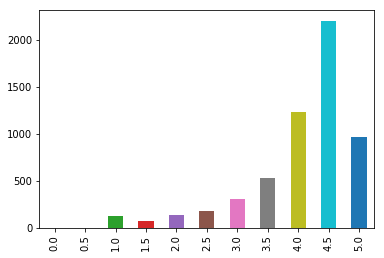

In [10]:
import seaborn as sns
cnt = full_data[target].value_counts().reindex(np.arange(0.0, 5.5, 0.5)).plot(kind='bar')



# Embeddings

In [11]:
def load_glove(word_index):
    EMBEDDING_FILE = '../input/quora-insincere-questions-classification/embeddings/glove.840B.300d/glove.840B.300d.txt'        
    emb_mean, emb_std = -0.005838499, 0.48782197
    embedding_matrix = np.random.normal(emb_mean, emb_std, (max_features, embed_size))
        
    with open(EMBEDDING_FILE, 'r', encoding="utf8") as f:
        for line in f:
            word, vec = line.split(' ', 1)
            if word not in word_index:
                continue
            i = word_index[word]
            if i >= max_features:
                continue
            embedding_vector = np.asarray(vec.split(' '), dtype='float32')[:300]
            if len(embedding_vector) == 300:
                embedding_matrix[i] = embedding_vector
            
    return embedding_matrix 
def load_fasttext(word_index):    
    EMBEDDING_FILE = '../input/quora-insincere-questions-classification/embeddings/wiki-news-300d-1M/wiki-news-300d-1M.vec'   
    emb_mean, emb_std = -0.0033469985, 0.109855495
    embedding_matrix = np.random.normal(emb_mean, emb_std, (max_features, embed_size))
        
    with open(EMBEDDING_FILE, 'r', encoding="utf8") as f:
        for line in f:
            word, vec = line.split(' ', 1)
            if word not in word_index:
                continue
            i = word_index[word]
            if i >= max_features:
                continue
            embedding_vector = np.asarray(vec.split(' '), dtype='float32')[:300]
            if len(embedding_vector) == 300:
                embedding_matrix[i] = embedding_vector

    return embedding_matrix

def load_para(word_index):
    EMBEDDING_FILE = '../input/quora-insincere-questions-classification/embeddings/paragram_300_sl999/paragram_300_sl999.txt'
    emb_mean, emb_std = -0.0053247833,0.49346462
    embedding_matrix = np.random.normal(emb_mean, emb_std, (max_features, embed_size))
        
    with open(EMBEDDING_FILE, 'r', encoding="latin-1") as f:
        for line in f:
            word, vec = line.split(' ', 1)
            if word not in word_index:
                continue
            i = word_index[word]
            if i >= max_features:
                continue
            embedding_vector = np.asarray(vec.split(' '), dtype='float32')[:300]
            if len(embedding_vector) == 300:
                embedding_matrix[i] = embedding_vector
            
    return embedding_matrix 

glove_embeddings = load_glove(word_index)
paragram_embeddings = load_para(word_index)
fasttext_embeddings = load_fasttext(word_index)

embedding_matrix = np.mean([glove_embeddings, paragram_embeddings, fasttext_embeddings], axis=0)
#np.mean([glove_embeddings, paragram_embeddings, fasttext_embeddings], axis=0)
#embedding_matrix = np.concatenate([glove_embeddings, paragram_embeddings], axis=0)

# add_lower(embedding_matrix, vocab)
del glove_embeddings, paragram_embeddings, fasttext_embeddings
gc.collect()

np.shape(embedding_matrix)

(120000, 300)

# Build the Recurrence Neural Network

## Set the initial parameters

In [12]:
import torch as t
import torch.nn as nn
import torch.nn.functional as F

embedding_dim = 300
use_pretrained_embedding = True

hidden_size = 400
gru_len = hidden_size

Routings = 4 #5
Num_capsule = 5
Dim_capsule = 5 #16
dropout_p = 0.25
rate_drop_dense = 0.28
LR = 0.0001
T_epsilon = 1e-7
num_classes = 30

## Class Initialization
Build the Class of the CyclicLR, Embed_Layer, GRU_Layer, Caps_Layer, Attention Layer, Gaussian noise regularizer and the NeuralNet

In [13]:
class CyclicLR(object):
    def __init__(self, optimizer, base_lr=1e-3, max_lr=6e-3,
                 step_size=2000, mode='triangular', gamma=1.,
                 scale_fn=None, scale_mode='cycle', last_batch_iteration=-1):

        if not isinstance(optimizer, Optimizer):
            raise TypeError('{} is not an Optimizer'.format(
                type(optimizer).__name__))
        self.optimizer = optimizer

        if isinstance(base_lr, list) or isinstance(base_lr, tuple):
            if len(base_lr) != len(optimizer.param_groups):
                raise ValueError("expected {} base_lr, got {}".format(
                    len(optimizer.param_groups), len(base_lr)))
            self.base_lrs = list(base_lr)
        else:
            self.base_lrs = [base_lr] * len(optimizer.param_groups)

        if isinstance(max_lr, list) or isinstance(max_lr, tuple):
            if len(max_lr) != len(optimizer.param_groups):
                raise ValueError("expected {} max_lr, got {}".format(
                    len(optimizer.param_groups), len(max_lr)))
            self.max_lrs = list(max_lr)
        else:
            self.max_lrs = [max_lr] * len(optimizer.param_groups)

        self.step_size = step_size

        if mode not in ['triangular', 'triangular2', 'exp_range'] \
                and scale_fn is None:
            raise ValueError('mode is invalid and scale_fn is None')

        self.mode = mode
        self.gamma = gamma

        if scale_fn is None:
            if self.mode == 'triangular':
                self.scale_fn = self._triangular_scale_fn
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = self._triangular2_scale_fn
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = self._exp_range_scale_fn
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode

        self.batch_step(last_batch_iteration + 1)
        self.last_batch_iteration = last_batch_iteration

    def batch_step(self, batch_iteration=None):
        if batch_iteration is None:
            batch_iteration = self.last_batch_iteration + 1
        self.last_batch_iteration = batch_iteration
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr

    def _triangular_scale_fn(self, x):
        return 1.

    def _triangular2_scale_fn(self, x):
        return 1 / (2. ** (x - 1))

    def _exp_range_scale_fn(self, x):
        return self.gamma**(x)

    def get_lr(self):
        step_size = float(self.step_size)
        cycle = np.floor(1 + self.last_batch_iteration / (2 * step_size))
        x = np.abs(self.last_batch_iteration / step_size - 2 * cycle + 1)

        lrs = []
        param_lrs = zip(self.optimizer.param_groups, self.base_lrs, self.max_lrs)
        for param_group, base_lr, max_lr in param_lrs:
            base_height = (max_lr - base_lr) * np.maximum(0, (1 - x))
            if self.scale_mode == 'cycle':
                lr = base_lr + base_height * self.scale_fn(cycle)
            else:
                lr = base_lr + base_height * self.scale_fn(self.last_batch_iteration)
            lrs.append(lr)
        return lrs
        
class Embed_Layer(nn.Module):
    def __init__(self, embedding_matrix=None, vocab_size=None, embedding_dim=300):
        super(Embed_Layer, self).__init__()
        self.encoder = nn.Embedding(vocab_size + 1, embedding_dim)
        if use_pretrained_embedding:
            # self.encoder.weight.data.copy_(t.from_numpy(np.load(embedding_path))) # 方法一，加载np.save的npy文件
            self.encoder.weight.data.copy_(t.from_numpy(embedding_matrix))  # 方法二

    def forward(self, x, dropout_p=0.25):
        return nn.Dropout(p=dropout_p)(self.encoder(x))


class GRU_Layer(nn.Module):
    def __init__(self):
        super(GRU_Layer, self).__init__()
        self.gru = nn.GRU(input_size=300,
                          hidden_size=gru_len,
                          bidirectional=True)
        # # if you uncomment /*from rnn_revised import * */, uncomment following code aswell
        # self.gru = RNNHardSigmoid('GRU', input_size=300,
        #                           hidden_size=gru_len,
        #                           bidirectional=True)
    def init_weights(self):
        ih = (param.data for name, param in self.named_parameters() if 'weight_ih' in name)
        hh = (param.data for name, param in self.named_parameters() if 'weight_hh' in name)
        b = (param.data for name, param in self.named_parameters() if 'bias' in name)
        for k in ih:
            nn.init.xavier_uniform_(k)
        for k in hh:
            nn.init.orthogonal_(k)
        for k in b:
            nn.init.constant_(k, 0)

    def forward(self, x):
        return self.gru(x)


# core caps_layer with squash func
class Caps_Layer(nn.Module):
    def __init__(self, input_dim_capsule=gru_len * 2, num_capsule=Num_capsule, dim_capsule=Dim_capsule, \
                 routings=Routings, kernel_size=(9, 1), share_weights=True,
                 activation='default', **kwargs):
        super(Caps_Layer, self).__init__(**kwargs)

        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings
        self.kernel_size = kernel_size
        self.share_weights = share_weights
        if activation == 'default':
            self.activation = self.squash
        else:
            self.activation = nn.ReLU(inplace=True)

        if self.share_weights:
            self.W = nn.Parameter(
                nn.init.xavier_normal_(t.empty(1, input_dim_capsule, self.num_capsule * self.dim_capsule)))
        else:
            self.W = nn.Parameter(
                t.randn(BATCH_SIZE, input_dim_capsule, self.num_capsule * self.dim_capsule))  # 64即batch_size

    def forward(self, x):

        if self.share_weights:
            u_hat_vecs = t.matmul(x, self.W)
        else:
            print('add later')

        batch_size = x.size(0)
        input_num_capsule = x.size(1)
        u_hat_vecs = u_hat_vecs.view((batch_size, input_num_capsule,
                                      self.num_capsule, self.dim_capsule))
        u_hat_vecs = u_hat_vecs.permute(0, 2, 1, 3)  # 转成(batch_size,num_capsule,input_num_capsule,dim_capsule)
        b = t.zeros_like(u_hat_vecs[:, :, :, 0])  # (batch_size,num_capsule,input_num_capsule)

        for i in range(self.routings):
            b = b.permute(0, 2, 1)
            c = F.softmax(b, dim=2)
            c = c.permute(0, 2, 1)
            b = b.permute(0, 2, 1)
            outputs = self.activation(t.einsum('bij,bijk->bik', (c, u_hat_vecs)))  # batch matrix multiplication
            # outputs shape (batch_size, num_capsule, dim_capsule)
            if i < self.routings - 1:
                b = t.einsum('bik,bijk->bij', (outputs, u_hat_vecs))  # batch matrix multiplication
        return outputs  # (batch_size, num_capsule, dim_capsule)

    # text version of squash, slight different from original one
    def squash(self, x, axis=-1):
        s_squared_norm = (x ** 2).sum(axis, keepdim=True)
        scale = t.sqrt(s_squared_norm + T_epsilon)
        return x / scale
    
class Capsule_Main(nn.Module):
    def __init__(self, embedding_matrix=None, vocab_size=None):
        super(Capsule_Main, self).__init__()
        self.embed_layer = Embed_Layer(embedding_matrix, vocab_size)
        self.gru_layer = GRU_Layer()
        self.gru_layer.init_weights()
        self.caps_layer = Caps_Layer()
        self.dense_layer = Dense_Layer()

    def forward(self, content):
        content1 = self.embed_layer(content)
        content2, _ = self.gru_layer(content1)
        content3 = self.caps_layer(content2)
        output = self.dense_layer(content3)
        return output


class Attention(nn.Module):
    def __init__(self, feature_dim, step_dim, bias=True, **kwargs):
        super(Attention, self).__init__(**kwargs)
        
        self.supports_masking = True

        self.bias = bias
        self.feature_dim = feature_dim
        self.step_dim = step_dim
        self.features_dim = 0
        
        weight = torch.zeros(feature_dim, 1)
        nn.init.xavier_uniform_(weight)
        self.weight = nn.Parameter(weight)
        
        if bias:
            self.b = nn.Parameter(torch.zeros(step_dim))
        
    def forward(self, x, mask=None):
        feature_dim = self.feature_dim
        step_dim = self.step_dim

        eij = torch.mm(
            x.contiguous().view(-1, feature_dim), 
            self.weight
        ).view(-1, step_dim)
        
        if self.bias:
            eij = eij + self.b
            
        eij = torch.tanh(eij)
        a = torch.exp(eij)
        
        if mask is not None:
            a = a * mask

        a = a / torch.sum(a, 1, keepdim=True) + 1e-10

        weighted_input = x * torch.unsqueeze(a, -1)
        return torch.sum(weighted_input, 1)

class GaussianNoise(nn.Module):
    """Gaussian noise regularizer.

    Args:
        sigma (float, optional): relative standard deviation used to generate the
            noise. Relative means that it will be multiplied by the magnitude of
            the value your are adding the noise to. This means that sigma can be
            the same regardless of the scale of the vector.
        is_relative_detach (bool, optional): whether to detach the variable before
            computing the scale of the noise. If `False` then the scale of the noise
            won't be seen as a constant but something to optimize: this will bias the
            network to generate vectors with smaller values.
    """

    def __init__(self, sigma=0.1, is_relative_detach=True):
        super().__init__()
        self.sigma = sigma
        self.is_relative_detach = is_relative_detach
        self.noise = torch.tensor(0).cuda().float()

    def forward(self, x):
        if self.training and self.sigma != 0:
            scale = self.sigma * x.detach() if self.is_relative_detach else self.sigma * x
            sampled_noise = self.noise.repeat(*x.size()).normal_() * scale
            x = x + sampled_noise
        return x
    
class NeuralNet(nn.Module):
    def __init__(self, mode=0, noise_flag=False):
        super(NeuralNet, self).__init__()
        
        fc_layer = 16
        fc_layer1 = 16

        self.embedding = nn.Embedding(max_features, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        
        self.embedding_dropout = nn.Dropout2d(0.1)
        self.lstm = nn.LSTM(embed_size, hidden_size, bidirectional=True, batch_first=True)
        self.gru = nn.GRU(hidden_size * 2, hidden_size, bidirectional=True, batch_first=True)
        self.gru0 = nn.GRU(embed_size, hidden_size, bidirectional=True, batch_first=True)

        self.lstm2 = nn.LSTM(hidden_size * 2, hidden_size, bidirectional=True, batch_first=True)

        self.lstm_attention = Attention(hidden_size * 2, maxlen)
        self.gru_attention = Attention(hidden_size * 2, maxlen)
        self.bn = nn.BatchNorm1d(16, momentum=0.5)
#         self.linear = nn.Linear(hidden_size*8+1+len(feature_list), fc_layer1)
        self.linear = nn.Linear(hidden_size*12+len(feature_list)-6, fc_layer1)#643:80 - 483:60 - 323:40
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(fc_layer**2,fc_layer)
        self.sigmoid = nn.Sigmoid()
        self.out = nn.Linear(fc_layer, 1)
        self.lincaps = nn.Linear(Num_capsule * Dim_capsule, 1)
        self.caps_layer = Caps_Layer()
        self.noise = GaussianNoise()
        #### 0 : lstm + gru, 1 : gru + gru, 2 : lstm + lstm
        self.mode = mode
        self.noise_flag = noise_flag
    
    def forward(self, x):
        h_embedding = self.embedding(x[0])
        h_embedding = torch.squeeze(
            self.embedding_dropout(torch.unsqueeze(h_embedding, 0)))
        
        if self.noise_flag:  
            h_embedding = self.noise(h_embedding)
        
        if self.mode == 0: 
            h_lstm, _ = self.lstm(h_embedding)
            h_gru, _ = self.gru(h_lstm)
        elif self.mode == 1:
            h_gru_0, _ = self.gru0(h_embedding)
            h_gru, _ = self.gru(h_gru_0)
        else:
            h_lstm, _ = self.lstm(h_embedding)
            h_lstm_2, _ = self.lstm2(h_lstm)


        
        ##Capsule Layer      
        if self.mode != 2:
            content3 = self.caps_layer(h_gru)
        else:
            content3 = self.caps_layer(h_lstm_2)
        
        content3 = self.dropout(content3)
        batch_size = content3.size(0)
        content3 = content3.view(batch_size, -1)
        content3 = self.relu(self.lincaps(content3))

        ##Attention Layer
        if self.mode == 0:
            h_lstm_atten = self.lstm_attention(h_lstm)
            h_gru_atten = self.gru_attention(h_gru)
        elif self.mode == 1:
            h_gru_0_atten = self.gru_attention(h_gru_0)
            h_gru_atten = self.gru_attention(h_gru)
        else:
            h_lstm_atten = self.lstm_attention(h_lstm)
            h_lstm_atten_2 = self.lstm_attention(h_lstm_2)
        
        if self.mode == 0:
            avg_pool = torch.mean(h_gru, 1)
            max_pool, _ = torch.max(h_gru, 1)
            avg_pool_0 = torch.mean(h_lstm, 1)
            max_pool_0, _ = torch.max(h_lstm, 1)
        elif self.mode == 1:
            avg_pool = torch.mean(h_gru, 1)
            max_pool, _ = torch.max(h_gru, 1)
            avg_pool_0 = torch.mean(h_gru_0, 1)
            max_pool_0, _ = torch.max(h_gru_0, 1)
        else:
            avg_pool = torch.mean(h_lstm_2, 1)
            max_pool, _ = torch.max(h_lstm_2, 1)
            avg_pool_0 = torch.mean(h_lstm, 1)
            max_pool_0, _ = torch.max(h_lstm, 1)
            
        f = torch.tensor(x[1], dtype=torch.float).cuda()
        
        if self.mode == 0:
            conc = torch.cat((h_lstm_atten, h_gru_atten, content3, avg_pool_0, max_pool_0, avg_pool, max_pool, f), 1)
        elif self.mode == 1:
            conc = torch.cat((h_gru_0_atten, h_gru_atten, content3, avg_pool_0, max_pool_0, avg_pool, max_pool, f), 1)
        else:
            conc = torch.cat((h_lstm_atten, h_lstm_atten_2, content3, avg_pool_0, max_pool_0, avg_pool, max_pool, f), 1)
        
        conc = self.linear(conc)
        if self.noise_flag:
            conc = self.noise(conc)
        conc = self.relu(conc)
        conc = self.bn(conc)
        conc = self.dropout(conc)

        out = self.out(conc)
        out = self.sigmoid(out)*5
        
        return out

In [14]:
class MyDataset(Dataset):
    def __init__(self,dataset):
        self.dataset = dataset

    def __getitem__(self, index):
        data, target = self.dataset[index]

        return data, target, index
    def __len__(self):
        return len(self.dataset)
        
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Loss Function

In [15]:
class My_loss(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x, y):
#         check = x - y
#         if abs(x-y) > 0.5:
#         return t.mean(t.exp(2*t.abs(x-y))) + t.mean(t.pow((x - y), 2))
        return t.mean(t.pow((x - y), 2))
#         return t.mean(t.pow((x - y), 2))
#         return t.mean(t.exp((x - y) * 4))

# Model Validation

In [16]:
# matrix for the out-of-fold predictions
train_preds = np.zeros((len(X_train)))
# matrix for the predictions on the test set
test_preds = np.zeros((len(X_test)))

# split the dataset

from sklearn.model_selection import KFold
# from sklearn.preprocessing import LabelEncoder
# label_encoder = LabelEncoder()
# y = label_encoder.fit_transform(target_labels)
# lb = preprocessing.LabelBinarizer()
# y_train_t = lb.fit(y_train*2)
# splits = list(StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED).split(X_train, y_train_t))

splits = list(KFold(n_splits= n_splits, random_state=None, shuffle=False).split(X_train, y_train))

x_test_cuda = torch.tensor(X_test, dtype=torch.long).cuda()
test = torch.utils.data.TensorDataset(x_test_cuda)
test_loader = torch.utils.data.DataLoader(test, batch_size= batch_size, drop_last = False, shuffle= False)

avg_losses_f = []
avg_val_losses_f = []
for i, (train_idx, valid_idx) in enumerate(splits):    
    # split data in train / validation according to the KFold indeces
    # also, convert them to a torch tensor and store them on the GPU (done with .cuda())
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    features = np.array(features)

    x_train_fold = torch.tensor(X_train[train_idx.astype(int)], dtype=torch.long).cuda()
    y_train_fold = torch.tensor(y_train[train_idx.astype(int), np.newaxis], dtype=torch.float32).cuda()
    
    kfold_X_features = features[train_idx.astype(int)]
    kfold_X_valid_features = features[valid_idx.astype(int)]
    
    x_val_fold = torch.tensor(X_train[valid_idx.astype(int)], dtype=torch.long).cuda()
    y_val_fold = torch.tensor(y_train[valid_idx.astype(int), np.newaxis], dtype=torch.float32).cuda()
    
    model = NeuralNet(mode=0, noise_flag=True)

    # make sure everything in the model is running on the GPU
    model.cuda()
    
    seed_everything(SEED+i)

    # note that the model returns logit to take advantage of the log-sum-exp trick 
    # for numerical stability in the lossMSE
    loss_fn = My_loss()

    step_size = 300
    base_lr, max_lr = 0.001, 0.003   
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), 
                             lr=max_lr)
    
    ################################################################################################
    scheduler = CyclicLR(optimizer, base_lr=base_lr, max_lr=max_lr,
               step_size=step_size, mode='exp_range',
               gamma=0.99994)
    ###############################################################################################

    train = torch.utils.data.TensorDataset(x_train_fold, y_train_fold)
    valid = torch.utils.data.TensorDataset(x_val_fold, y_val_fold)
    
    train = MyDataset(train)
    valid = MyDataset(valid)

    ##No need to shuffle the data again here. Shuffling happens when splitting for kfolds.
    train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, drop_last = True, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, drop_last = True, shuffle=True)
    
    print(f'Fold {i + 1}')
    for epoch in range(n_epochs):
        # set train mode of the model. This enables operations which are only applied during training like dropout
        start_time = time.time()
        model.train()

        avg_loss = 0.  
        for i, (x_batch, y_batch, index) in enumerate(train_loader):
            # Forward pass: compute predicted y by passing x to the model.
            ################################################################################################            
            f = kfold_X_features[index]
            y_pred = model([x_batch,f])
            ################################################################################################
            if scheduler:
                scheduler.batch_step()
            ################################################################################################
            # Compute and print loss.
            loss = loss_fn(y_pred, y_batch)
            # Before the backward pass, use the optimizer object to zero all of the
            # gradients for the Tensors it will update (which are the learnable weights
            # of the model)
            optimizer.zero_grad()

            # Backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()

            # Calling the step function on an Optimizer makes an update to its parameters
            optimizer.step()
            avg_loss += loss.item() / len(train_loader)
            
        # set evaluation mode of the model. This disabled operations which are only applied during training like dropout
        model.eval()
        
        # predict all the samples in y_val_fold batch per batch
        valid_preds_fold = np.zeros((x_val_fold.size(0)))
        test_preds_fold = np.zeros((len(X_test)))
        
        avg_val_loss = 0.
        for i, (x_batch, y_batch, index) in enumerate(valid_loader):
            f = kfold_X_valid_features[index]
    
            y_pred = model([x_batch,f]).detach()
            
            avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
            valid_preds_fold[i * batch_size:(i+1) * batch_size] = y_pred.cpu().numpy()[:, 0]
        
        elapsed_time = time.time() - start_time 
        print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f} \t time={:.2f}s'.format(
            epoch + 1, n_epochs, avg_loss, avg_val_loss, elapsed_time))
    avg_losses_f.append(avg_loss)
    avg_val_losses_f.append(avg_val_loss) 
    # predict all samples in the test set batch per batch
    for i, (x_batch,) in enumerate(test_loader):
        f = test_features[i * batch_size:(i+1) * batch_size]
        y_pred = model([x_batch,f]).detach()
        test_preds_fold[i * batch_size:(i+1) * batch_size] = y_pred.cpu().numpy()[:, 0]
        
    train_preds[valid_idx] = valid_preds_fold
    test_preds += test_preds_fold / len(splits)

print('All \t loss={:.4f} \t val_loss={:.4f} \t '.format(np.average(avg_losses_f),np.average(avg_val_losses_f)))

def bestThresshold(y_train,train_preds):
    print('Mean_squared_error: {:.4f}'.format(mean_squared_error(y_train, np.array(train_preds))))
bestThresshold(y_test[target],test_preds)


Fold 1
Epoch 1/40 	 loss=3.0449 	 val_loss=2.6479 	 time=1.34s
Epoch 2/40 	 loss=2.9183 	 val_loss=3.0170 	 time=1.26s
Epoch 3/40 	 loss=2.8532 	 val_loss=1.9996 	 time=1.26s
Epoch 4/40 	 loss=2.7473 	 val_loss=2.8033 	 time=1.26s
Epoch 5/40 	 loss=2.6548 	 val_loss=1.2024 	 time=1.26s
Epoch 6/40 	 loss=2.5525 	 val_loss=2.4745 	 time=1.26s
Epoch 7/40 	 loss=2.4467 	 val_loss=2.4306 	 time=1.26s
Epoch 8/40 	 loss=2.3264 	 val_loss=3.7817 	 time=1.26s
Epoch 9/40 	 loss=2.1938 	 val_loss=1.4386 	 time=1.26s
Epoch 10/40 	 loss=2.0764 	 val_loss=2.2976 	 time=1.26s
Epoch 11/40 	 loss=2.0630 	 val_loss=1.0444 	 time=1.27s
Epoch 12/40 	 loss=1.9906 	 val_loss=1.7393 	 time=1.26s
Epoch 13/40 	 loss=2.2775 	 val_loss=2.6736 	 time=1.26s
Epoch 14/40 	 loss=2.3970 	 val_loss=2.3627 	 time=1.26s
Epoch 15/40 	 loss=2.2751 	 val_loss=2.2770 	 time=1.27s
Epoch 16/40 	 loss=2.1191 	 val_loss=1.8431 	 time=1.27s
Epoch 17/40 	 loss=1.6856 	 val_loss=2.4523 	 time=1.26s
Epoch 18/40 	 loss=1.4206 	 val_l

# Accuracy Prediction without 0

In [17]:
# y_test.columns
# plt.figure(12)
# cnt2 = y_test[target].value_counts().reindex(np.arange(0.0, 5.5, 0.5)).plot(kind='bar')
# plt.figure(22)
# cnt3 = y_test['adjust_prediction'].value_counts().reindex(np.arange(0.0, 5.5, 0.5)).plot(kind='bar')

In [18]:
test_adjust = []
for i in range(0, len(test_preds)):
    if test_preds[i] >= 0 and test_preds[i] < 1:
        val = 1
        test_adjust.append(val)
    elif test_preds[i] >= 4.75 and test_preds[i] <= 5:
        val = 5
        test_adjust.append(val)
    else:
        k = 1
        while k <= 10:
            if test_preds[i] >= 0.5*k + 0.25 and test_preds[i] < 0.5*k + 0.75:
                val = k*0.5+0.5
                test_adjust.append(val)
                break        
            k += 1
y_test['prediction'] = test_preds
y_test['adjust_prediction'] = test_adjust
print(y_test)

from sklearn.metrics import accuracy_score
accuracy_score(y_test[target].astype('S'), y_test['adjust_prediction'].astype('S'))

            user_rating_ver  prediction  adjust_prediction
id                                                        
640364616               4.5    4.420182                4.5
1100292960              4.5    4.124547                4.0
1074222293              3.5    4.306051                4.5
1071976079              3.0    4.129136                4.0
991558368               4.5    3.090697                3.0
519052678               5.0    4.074309                4.0
548946769               2.5    3.973880                4.0
720825227               5.0    4.334541                4.5
1088300283              5.0    4.236174                4.0
448142450               4.5    3.364941                3.5
341776037               4.5    3.717594                3.5
1123795045              3.0    3.980859                4.0
435476174               3.5    4.240653                4.0
1078665338              2.0    3.466583                3.5
1134867821              3.0    4.434385                4

0.3138390272148234

# Plot the analysis result

{'whiskers': [<matplotlib.lines.Line2D at 0x7f01339cb860>,
 'caps': [<matplotlib.lines.Line2D at 0x7f01339cbf28>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f01339cb710>],
 'medians': [<matplotlib.lines.Line2D at 0x7f01339d35f8>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f01339d3940>],
 'means': []}

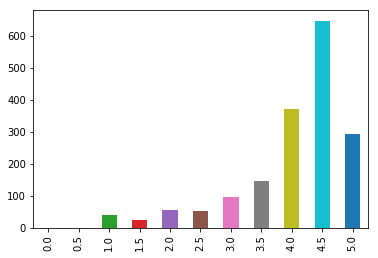

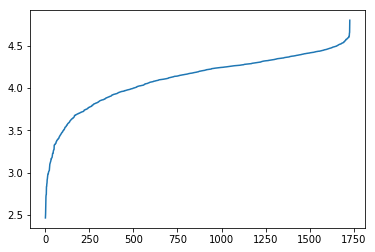

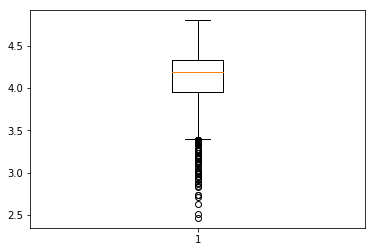

In [19]:
from matplotlib import pyplot as plt
y_test.columns
plt.figure(12)
cnt2 = y_test[target].value_counts().reindex(np.arange(0.0, 5.5, 0.5)).plot(kind='bar')
# plt.figure(22)
# cnt3 = y_test['adjust_prediction'].value_counts().reindex(np.arange(0.0, 5.5, 0.5)).plot(kind='bar')
plt.figure(21)
order_test = sorted(y_test['prediction'].values)
x = np.arange(len(order_test))+1
plt.plot(x, order_test)
plt.figure(22)
plt.boxplot(order_test)


(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   5.,
         11.,  28.,  58., 131., 266., 525., 630.,  71.,   1.,   0.]),
 array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 ,
        2.75, 3.  , 3.25, 3.5 , 3.75, 4.  , 4.25, 4.5 , 4.75, 5.  , 5.25]),
 <a list of 21 Patch objects>)

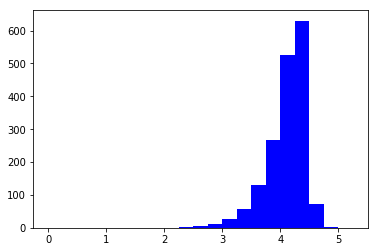

In [20]:
binsize = 0.25
bins = np.arange(0, 5.5, binsize)
plt.hist(y_test['prediction'].values, bins = bins, color = 'b')